<a href="https://colab.research.google.com/github/indrasary/tutorial-klasifikasi-toxic-word/blob/main/lstm_empathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip3 install tensorflow==2.9

In [ ]:
# !pip3 install tensorflow-metal==0.5.0

In [ ]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [ ]:
import keras.backend as K
# if len(K.tensorflow_backend._get_available_gpus()) > 0:
#   from keras.layers import CuDNNLSTM as LSTM
#   from keras.layers import CuDNNGRU as GRU


# Download the data:
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
# https://lazyprogrammer.me/course_files/toxic_comment_train.csv
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip


In [ ]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join("drive/MyDrive/ColabNotebooks/glove.6B/", "glove.6B.%sd.txt" % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


# New Section

In [ ]:
# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("drive/MyDrive/ColabNotebooks/train_en.csv", delimiter=';')
sentences = (train["doctor"]+";"+train["patient"]).fillna("DUMMY_VALUE").values
possible_labels = ["AE", "CE"]
targets = train[possible_labels].fillna('0').values
print(sentences[0:5])
print(targets[0:5])

Loading in comments...
['What brings you in here today?;Yeah, I have this pain in my chest'
 "OK, and where is the pain exactly? ;It's just right  over on the on the left side"
 'OK, and when did this pain start?;It started just 30 minutes ago'
 'OK, and did it just come on randomly or were you doing something strenuous?; I was just shovelling the driveway and it came on'
 "OK, and has that pain been getting worse at all over the last half an hour?;No, it just came on suddenly and it's uh, uh, I'm sorry. Yeah the pain has been there this whole time and it's gotten worse ever since it started"]
[['1' '0']
 ['0' '1']
 ['0' '1']
 ['0' '1']
 ['0' '1']]


In [ ]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [ ]:
# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 2192 unique tokens.


In [ ]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print(data[1])

Shape of data tensor: (1379, 100)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   4   2 129  29   5  27 293
  26  22  55  99  36   5  36   5 174 234]


In [ ]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [ ]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [ ]:
print('Building model...')

# create an LSTM network with a single LSTM
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x)
# x = Bidirectional(LSTM(15, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)
print(output[2])
model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(learning_rate=0.0001),
  metrics=['accuracy'],
)

Building model...
KerasTensor(type_spec=TensorSpec(shape=(2,), dtype=tf.float32, name=None), name='tf.__operators__.getitem_1/strided_slice:0', description="created by layer 'tf.__operators__.getitem_1'")


In [ ]:
print('Training model...')
r = model.fit(
  data[0:2],
  targets[0:2],
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Epoch 1/5


UnimplementedError: ignored

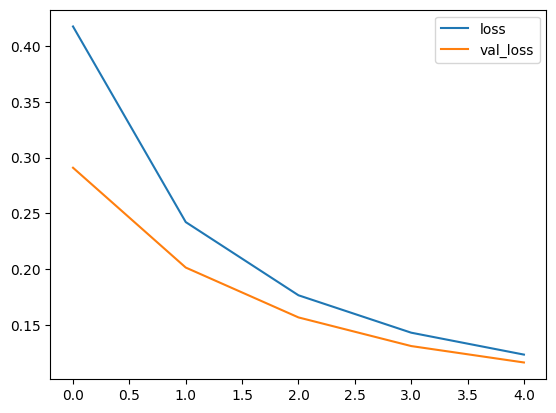

In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

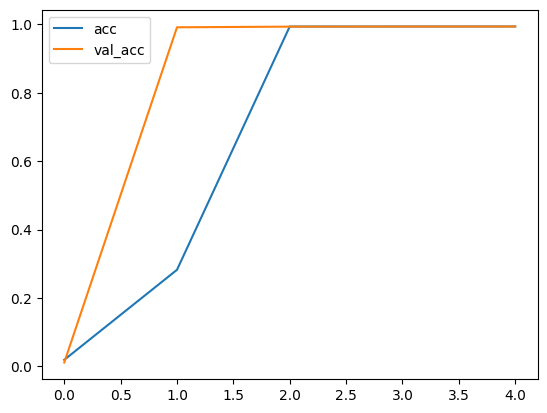

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
p = model.predict(data)
aucs = []
for j in range(5):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))
print()

4987/4987 [==============================] - 74s 15ms/step
0.8029932437918582

